In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [2]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
df.shape

(10000, 14)

In [3]:
df.duplicated().sum()

np.int64(0)

In [10]:
import pandas as pd

df_sample = df.sample(n=3000, random_state=42)
df_sample.to_csv("Churn_Modelling_3000.csv", index=False)

In [11]:
df=pd.read_csv("Churn_Modelling_3000.csv")
df.shape

(3000, 14)

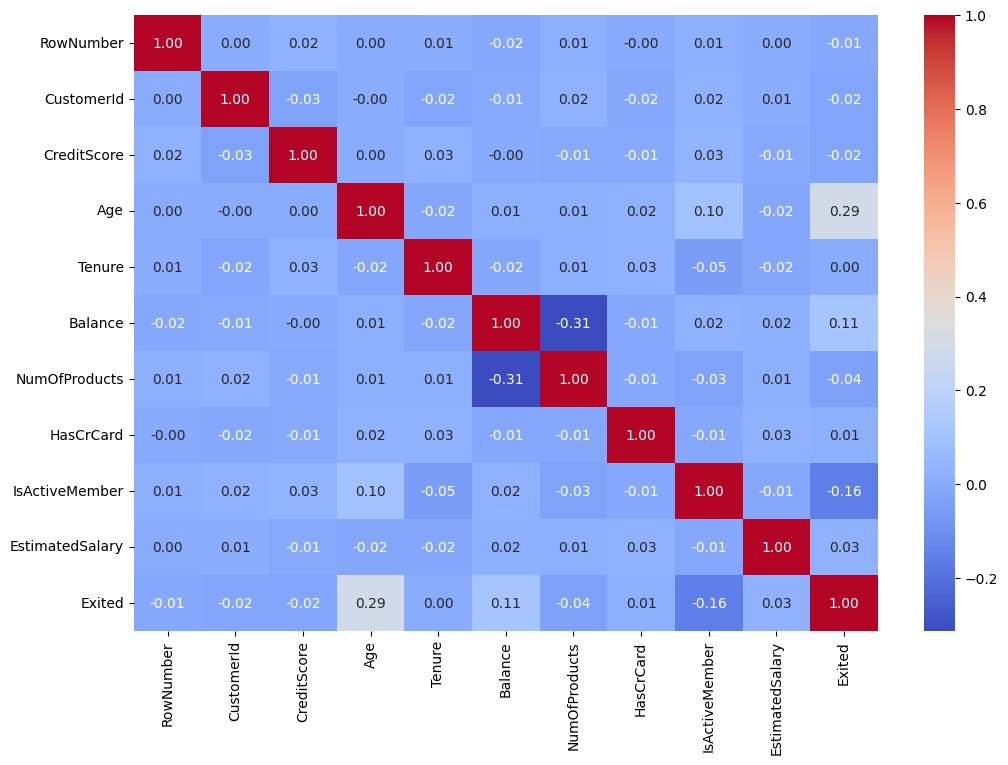

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Churn_Modelling_3000.csv")

plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()



In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("Churn_Modelling_3000.csv")

X = df.drop(columns=["Exited"])
y = df["Exited"]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
important_features = importances.sort_values(ascending=False)
print(important_features)


Age                0.200329
NumOfProducts      0.109514
CreditScore        0.091426
RowNumber          0.091017
EstimatedSalary    0.089989
Balance            0.089546
CustomerId         0.089044
Surname            0.085915
Tenure             0.052791
IsActiveMember     0.041104
Geography          0.029953
Gender             0.016730
HasCrCard          0.012642
dtype: float64


In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("Churn_Modelling_3000.csv")
X = df.drop(columns=["Exited"])
y = df["Exited"]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(8).index

df_top = df[top_features.tolist() + ["Exited"]]
df_top.to_csv("Churn_Modelling_3000_Top8.csv", index=False)


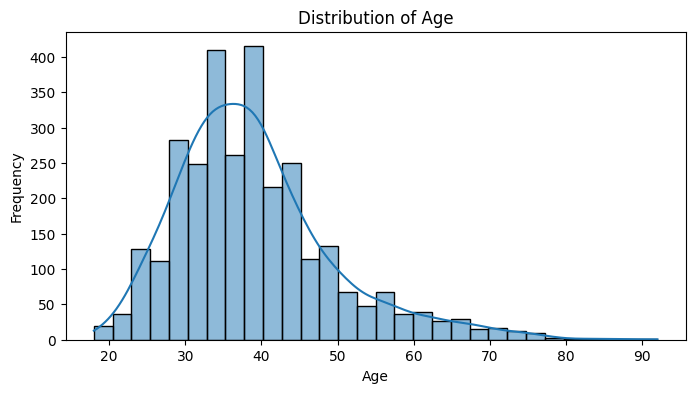

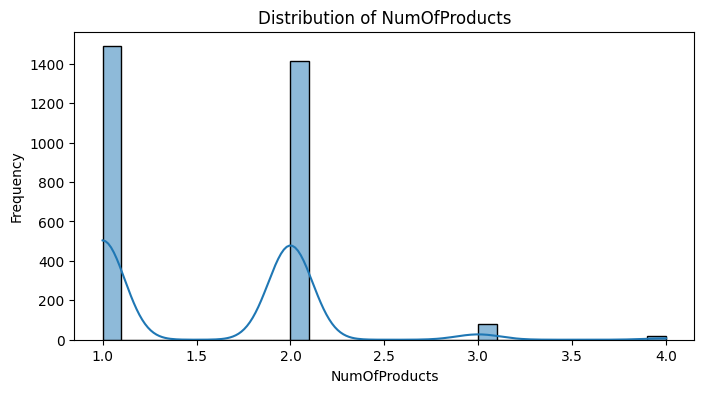

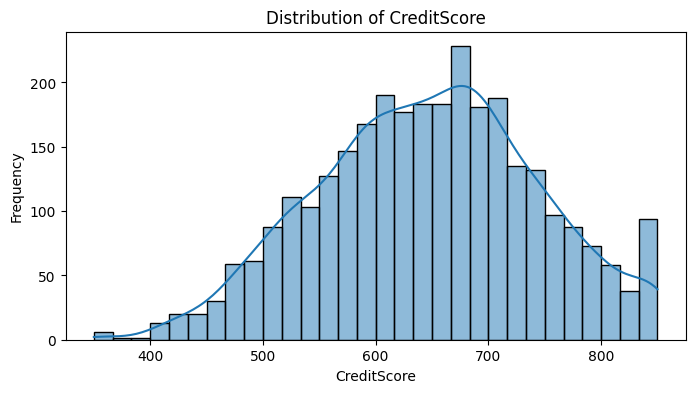

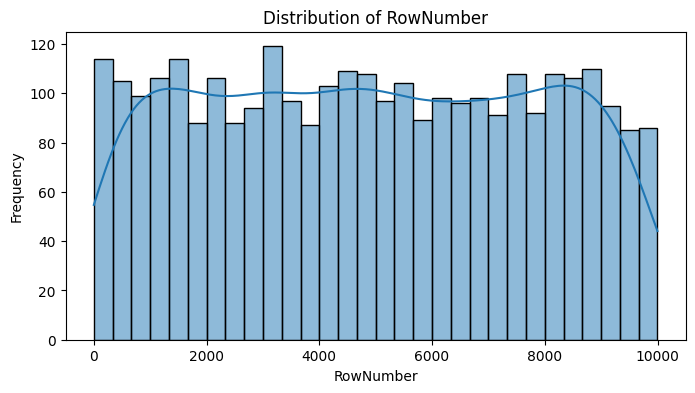

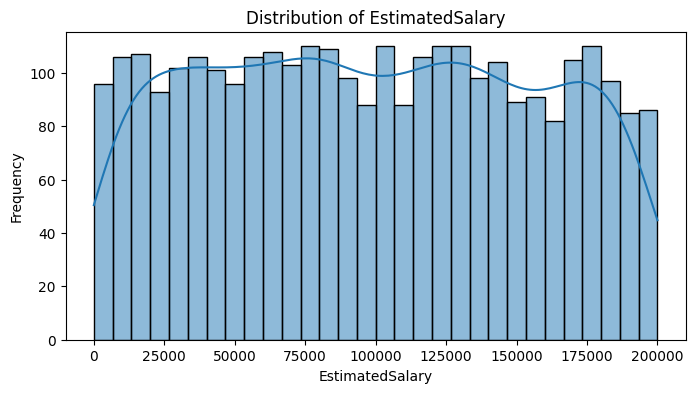

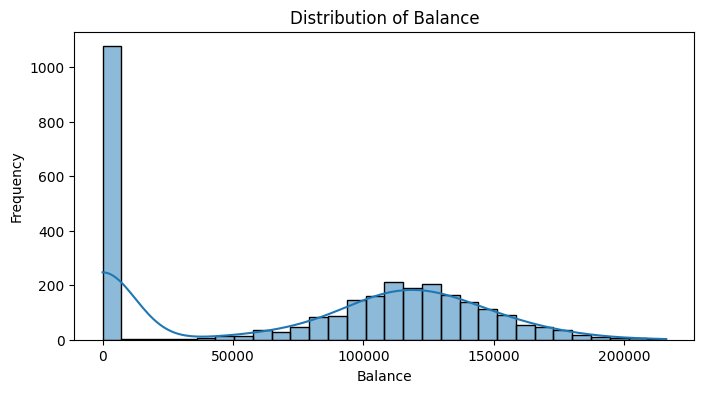

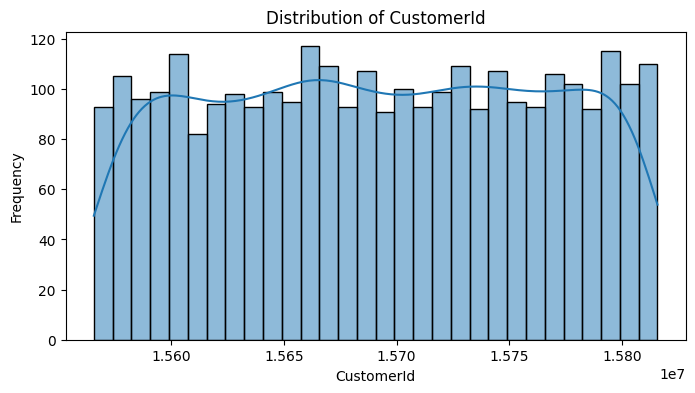

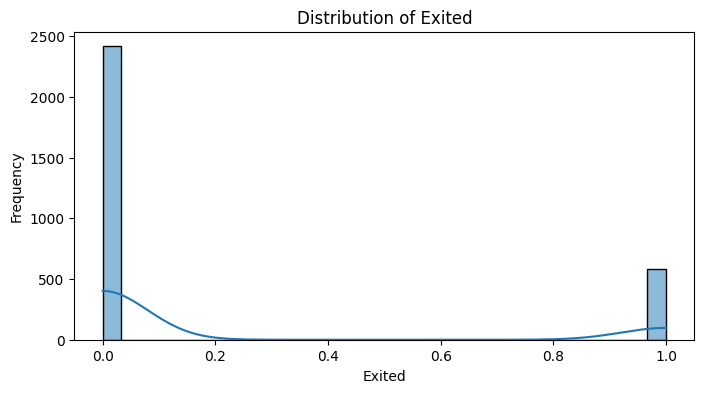

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df_top.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df_top[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

df = pd.read_csv("Churn_Modelling_3000_Top8.csv")
X = df.drop(columns=["Exited"])
y = df["Exited"]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

rf.fit(X_train_res, y_train_res)
dt.fit(X_train_res, y_train_res)
xgb_model.fit(X_train_res, y_train_res)

models = {"Random Forest": rf, "Decision Tree": dt, "XGBoost": xgb_model}

best_model_name = None
best_accuracy = 0

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    if acc > best_accuracy:
        best_accuracy = acc
        best_model_name = name

pred_train = np.column_stack([rf.predict(X_train_res), dt.predict(X_train_res), xgb_model.predict(X_train_res)])
pred_test = np.column_stack([rf.predict(X_test), dt.predict(X_test), xgb_model.predict(X_test)])

ann = Sequential()
ann.add(Dense(16, input_dim=3, activation='relu'))
ann.add(Dense(8, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(pred_train, y_train_res, epochs=20, batch_size=32, verbose=1)

y_pred_ann = (ann.predict(pred_test) > 0.5).astype(int)
ann_acc = accuracy_score(y_test, y_pred_ann)
print(f"\nANN Accuracy: {ann_acc:.4f}")
print(classification_report(y_test, y_pred_ann))

if ann_acc > best_accuracy:
    best_model_name = "ANN"
    best_accuracy = ann_acc

print(f"\nBest performing model: {best_model_name} with accuracy {best_accuracy:.4f}")


d:\AI_WORKFORCE\ANN\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:05:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest Accuracy: 0.8350
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       485
           1       0.57      0.60      0.58       115

    accuracy                           0.83       600
   macro avg       0.73      0.75      0.74       600
weighted avg       0.84      0.83      0.84       600


Decision Tree Accuracy: 0.7433
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       485
           1       0.37      0.48      0.42       115

    accuracy                           0.74       600
   macro avg       0.62      0.64      0.63       600
weighted avg       0.77      0.74      0.76       600


XGBoost Accuracy: 0.8183
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       485
           1       0.53      0.54      0.53       115

    accuracy                           0.82       600
   macro avg       0.71      0.71     

d:\AI_WORKFORCE\ANN\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6807 - loss: 0.6107
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9992 - loss: 0.2719
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0866
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0322
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0157
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0091
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0059
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0030
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 12/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

d:\AI_WORKFORCE\ANN\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:01:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Threshold: 0.47
Accuracy: 0.853
Precision: 0.67
Recall: 0.55
F1-score: 0.6
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.67      0.55      0.60       407

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.85      0.85      0.85      2000



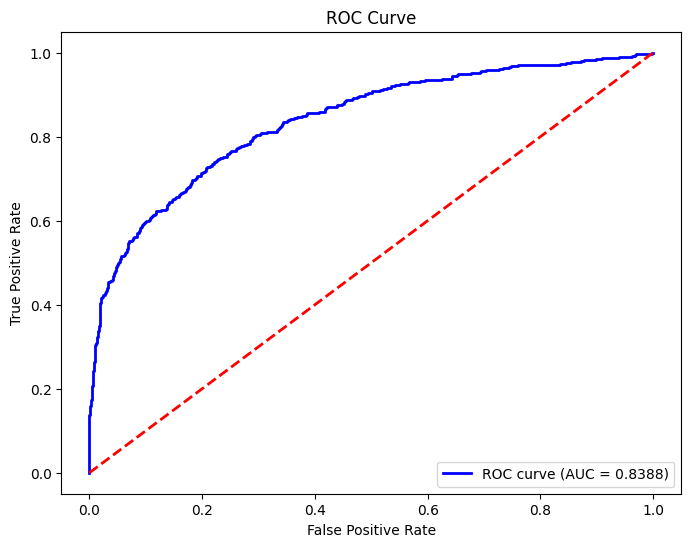

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, f1_score, precision_score, recall_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

df = pd.read_csv("Churn_Modelling.csv")
X = df.drop(columns=["Exited"])
y = df["Exited"]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_thresh = thresholds[f1_scores[:-1].argmax()]
y_pred = (y_pred_proba >= best_thresh).astype(int)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Threshold:", round(best_thresh,2))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", round(precision_score(y_test, y_pred),2))
print("Recall:", round(recall_score(y_test, y_pred),2))
print("F1-score:", round(f1_score(y_test, y_pred),2))
print(classification_report(y_test, y_pred))


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0,1],[0,1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



In [39]:
import joblib
joblib.dump(best_model, "xgb_churn_model.pkl")


['xgb_churn_model.pkl']

d:\AI_WORKFORCE\ANN\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:47:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best Threshold: 0.47
Accuracy: 0.853
Precision: 0.67
Recall: 0.55
F1-score: 0.6
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.67      0.55      0.60       407

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.85      0.85      0.85      2000



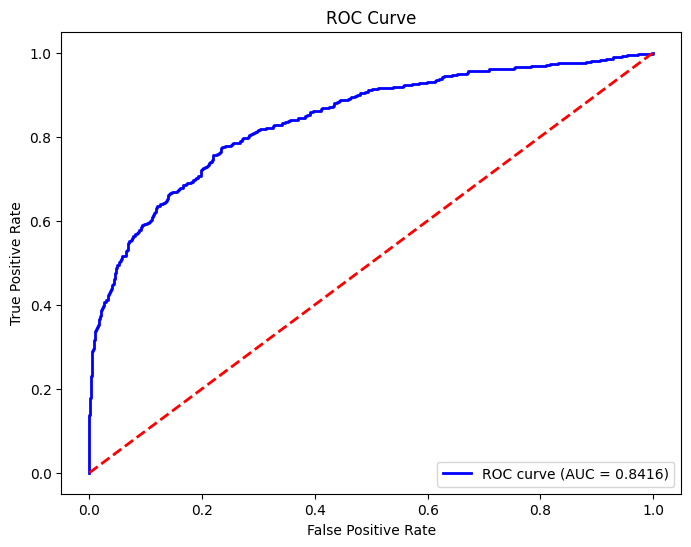

In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, f1_score, precision_score, recall_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

df = pd.read_csv("Churn_Modelling.csv")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop("Exited")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, np.where(df[col] > upper, upper, df[col]))

X = df.drop(columns=["Exited"])
y = df["Exited"]
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_thresh = thresholds[f1_scores[:-1].argmax()]
y_pred = (y_pred_proba >= best_thresh).astype(int)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Threshold:", round(best_thresh,2))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", round(precision_score(y_test, y_pred),2))
print("Recall:", round(recall_score(y_test, y_pred),2))
print("F1-score:", round(f1_score(y_test, y_pred),2))
print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0,1],[0,1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
